In [1]:
from pathlib import Path
training_dir = Path(r"E:\Trackmania Data\training_val_data\training_data")
validation_dir = Path(r"E:\Trackmania Data\training_val_data\validation_data")
test_dir = Path(r"E:\Trackmania Data\test_data")

In [2]:
import tensorflow as tf

from keras.models import Model
from keras import layers
from keras import backend as K


C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [3]:

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
batch_size = 20

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(32, 32),  # height, width
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical"
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(32, 32),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical"
)

class_indices = train_generator.class_indices
index_class_dict = {v: k for k, v in train_generator.class_indices.items()}
print(index_class_dict)

Found 100372 images belonging to 6 classes.


Found 36129 images belonging to 6 classes.


{0: 'A', 1: 'AW', 2: 'D', 3: 'DW', 4: 'W', 5: 'no_key'}


keras_preprocessing.image.DirectoryIterator

In [4]:
from collections import Counter

counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))
class_weights = {class_id: min(max_val / num_images, 20) for class_id, num_images in counter.items()}


In [15]:
train_generator.class_indices

{'A': 0,
 'AS': 1,
 'AW': 2,
 'D': 3,
 'DS': 4,
 'DW': 5,
 'S': 6,
 'W': 7,
 'no_key': 8}

In [5]:
counter

Counter({0: 337, 1: 3439, 2: 335, 3: 3421, 4: 17974, 5: 545})

In [6]:
class_weights

{0: 20, 1: 5.226519337016574, 2: 20, 3: 5.254019292604502, 4: 1.0, 5: 20}

In [18]:

img_input = layers.Input(shape=(64, 160, 1))


# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x4 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D((2, 4))(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(6, activation='softmax')(x)

model = Model(img_input, output)


In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 160, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 158, 16)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 39, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 8, 64)          0         
__________

In [17]:
# https://stackoverflow.com/questions/41458859/keras-custom-metric-for-single-class-accuracy#41717938
from keras import backend as K
interesting_class_id = 0  # Choose the class of interest: "A"


def single_class_accuracy(y_true, y_pred):

    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    # Replace class_id_preds with class_id_true for recall here
    accuracy_mask = K.cast(K.equal(class_id_preds, interesting_class_id), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

In [18]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['acc', single_class_accuracy])

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath=r"E:\Trackmania Data\checkpoints\checkpoint.{epoch:02d}-{val_loss:.2f}.hdf5", 
                               verbose=1, 
                               save_best_only=True, 
                               period=3)
from keras.callbacks import TensorBoard
tensboard = TensorBoard(log_dir=r"E:\Trackmania Data\logs", 
                        histogram_freq=5, 
                        batch_size=batch_size, 
                        write_grads=True, 
                        write_images=True)

In [12]:
train_generator.samples

26051

In [13]:
model.evaluate_generator(train_generator)

[1.7903725726193263, 0.1160799994258788, 0.04964620679948306]

In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//batch_size,
    verbose=2,
    class_weight=class_weights,
    callbacks=[checkpointer, tensboard]
    # initial_epoch=0
)

Epoch 1/50


 - 249s - loss: 2.3034 - acc: 0.6642 - single_class_accuracy: 0.5016 - val_loss: 0.5715 - val_acc: 0.7661 - val_single_class_accuracy: 0.6878


Epoch 2/50


 - 241s - loss: 1.1218 - acc: 0.7817 - single_class_accuracy: 0.6158 - val_loss: 0.5283 - val_acc: 0.7770 - val_single_class_accuracy: 0.6525


Epoch 3/50


 - 234s - loss: 0.8219 - acc: 0.8281 - single_class_accuracy: 0.6717 - val_loss: 0.2768 - val_acc: 0.8855 - val_single_class_accuracy: 0.8278


Epoch 4/50


 - 245s - loss: 0.6507 - acc: 0.8587 - single_class_accuracy: 0.7036 - val_loss: 0.3349 - val_acc: 0.8657 - val_single_class_accuracy: 0.7800


Epoch 5/50


 - 255s - loss: 0.5700 - acc: 0.8806 - single_class_accuracy: 0.7339 - val_loss: 0.3296 - val_acc: 0.8724 - val_single_class_accuracy: 0.7693


Epoch 6/50


 - 254s - loss: 0.4598 - acc: 0.9009 - single_class_accuracy: 0.7525 - val_loss: 0.3247 - val_acc: 0.8824 - val_single_class_accuracy: 0.7690


Epoch 7/50


 - 245s - loss: 0.4371 - acc: 0.9062 - single_class_accuracy: 0.7683 - val_loss: 0.2885 - val_acc: 0.8992 - val_single_class_accuracy: 0.7648


Epoch 8/50


 - 258s - loss: 0.3959 - acc: 0.9185 - single_class_accuracy: 0.7815 - val_loss: 0.2367 - val_acc: 0.9189 - val_single_class_accuracy: 0.8658


Epoch 9/50


 - 247s - loss: 0.3486 - acc: 0.9284 - single_class_accuracy: 0.8013 - val_loss: 0.2514 - val_acc: 0.9145 - val_single_class_accuracy: 0.7699


Epoch 10/50


 - 239s - loss: 0.2985 - acc: 0.9354 - single_class_accuracy: 0.8149 - val_loss: 0.1977 - val_acc: 0.9304 - val_single_class_accuracy: 0.8375


Epoch 11/50


 - 230s - loss: 0.2870 - acc: 0.9415 - single_class_accuracy: 0.8098 - val_loss: 0.1643 - val_acc: 0.9385 - val_single_class_accuracy: 0.8666


Epoch 12/50


 - 228s - loss: 0.3053 - acc: 0.9381 - single_class_accuracy: 0.8184 - val_loss: 0.1636 - val_acc: 0.9391 - val_single_class_accuracy: 0.8672


Epoch 13/50


 - 228s - loss: 0.2356 - acc: 0.9504 - single_class_accuracy: 0.8303 - val_loss: 0.2288 - val_acc: 0.9214 - val_single_class_accuracy: 0.7968


Epoch 14/50


 - 228s - loss: 0.2842 - acc: 0.9464 - single_class_accuracy: 0.8232 - val_loss: 0.2874 - val_acc: 0.9028 - val_single_class_accuracy: 0.7953


Epoch 15/50


 - 229s - loss: 0.2308 - acc: 0.9536 - single_class_accuracy: 0.8417 - val_loss: 0.1897 - val_acc: 0.9348 - val_single_class_accuracy: 0.8631


Epoch 16/50


 - 228s - loss: 0.2216 - acc: 0.9533 - single_class_accuracy: 0.8380 - val_loss: 0.2087 - val_acc: 0.9268 - val_single_class_accuracy: 0.8827


Epoch 17/50


 - 227s - loss: 0.2114 - acc: 0.9577 - single_class_accuracy: 0.8516 - val_loss: 0.1988 - val_acc: 0.9353 - val_single_class_accuracy: 0.8649


Epoch 18/50


 - 227s - loss: 0.1753 - acc: 0.9625 - single_class_accuracy: 0.8587 - val_loss: 0.1593 - val_acc: 0.9506 - val_single_class_accuracy: 0.9028


Epoch 19/50


 - 228s - loss: 0.2062 - acc: 0.9584 - single_class_accuracy: 0.8510 - val_loss: 0.1956 - val_acc: 0.9440 - val_single_class_accuracy: 0.8455


Epoch 20/50


 - 227s - loss: 0.1827 - acc: 0.9662 - single_class_accuracy: 0.8623 - val_loss: 0.1869 - val_acc: 0.9448 - val_single_class_accuracy: 0.8966


Epoch 21/50


 - 227s - loss: 0.1966 - acc: 0.9620 - single_class_accuracy: 0.8637 - val_loss: 0.2812 - val_acc: 0.9161 - val_single_class_accuracy: 0.8541


Epoch 22/50


 - 227s - loss: 0.1914 - acc: 0.9652 - single_class_accuracy: 0.8825 - val_loss: 0.1718 - val_acc: 0.9525 - val_single_class_accuracy: 0.8831


Epoch 23/50


 - 227s - loss: 0.1545 - acc: 0.9706 - single_class_accuracy: 0.8682 - val_loss: 0.1802 - val_acc: 0.9481 - val_single_class_accuracy: 0.8708


Epoch 24/50


 - 228s - loss: 0.1671 - acc: 0.9657 - single_class_accuracy: 0.8718 - val_loss: 0.2139 - val_acc: 0.9362 - val_single_class_accuracy: 0.8611


Epoch 25/50


 - 228s - loss: 0.1806 - acc: 0.9691 - single_class_accuracy: 0.8631 - val_loss: 0.2889 - val_acc: 0.9151 - val_single_class_accuracy: 0.8329


Epoch 26/50


 - 227s - loss: 0.1998 - acc: 0.9657 - single_class_accuracy: 0.8657 - val_loss: 0.1437 - val_acc: 0.9612 - val_single_class_accuracy: 0.9237


Epoch 27/50


 - 228s - loss: 0.1864 - acc: 0.9701 - single_class_accuracy: 0.8695 - val_loss: 0.2253 - val_acc: 0.9336 - val_single_class_accuracy: 0.8857


Epoch 28/50


 - 227s - loss: 0.1579 - acc: 0.9709 - single_class_accuracy: 0.8807 - val_loss: 0.1443 - val_acc: 0.9598 - val_single_class_accuracy: 0.9155


Epoch 29/50


 - 227s - loss: 0.1248 - acc: 0.9748 - single_class_accuracy: 0.8857 - val_loss: 0.1905 - val_acc: 0.9481 - val_single_class_accuracy: 0.9177


Epoch 30/50


 - 227s - loss: 0.1397 - acc: 0.9730 - single_class_accuracy: 0.8822 - val_loss: 0.1704 - val_acc: 0.9571 - val_single_class_accuracy: 0.8886


Epoch 31/50


 - 227s - loss: 0.1356 - acc: 0.9731 - single_class_accuracy: 0.8885 - val_loss: 0.2510 - val_acc: 0.9363 - val_single_class_accuracy: 0.8610


Epoch 32/50


 - 227s - loss: 0.1225 - acc: 0.9757 - single_class_accuracy: 0.8909 - val_loss: 0.1794 - val_acc: 0.9558 - val_single_class_accuracy: 0.9229


Epoch 33/50


 - 227s - loss: 0.1608 - acc: 0.9725 - single_class_accuracy: 0.8864 - val_loss: 0.1745 - val_acc: 0.9519 - val_single_class_accuracy: 0.8926


Epoch 34/50


 - 227s - loss: 0.1092 - acc: 0.9788 - single_class_accuracy: 0.8987 - val_loss: 0.1628 - val_acc: 0.9584 - val_single_class_accuracy: 0.9072


Epoch 35/50


 - 227s - loss: 0.1429 - acc: 0.9741 - single_class_accuracy: 0.8806 - val_loss: 0.1849 - val_acc: 0.9472 - val_single_class_accuracy: 0.8795


Epoch 36/50


 - 227s - loss: 0.1432 - acc: 0.9742 - single_class_accuracy: 0.8833 - val_loss: 0.1638 - val_acc: 0.9533 - val_single_class_accuracy: 0.8930


Epoch 37/50


 - 227s - loss: 0.1122 - acc: 0.9765 - single_class_accuracy: 0.8781 - val_loss: 0.1645 - val_acc: 0.9570 - val_single_class_accuracy: 0.9202


Epoch 38/50


 - 227s - loss: 0.1471 - acc: 0.9766 - single_class_accuracy: 0.8963 - val_loss: 0.1632 - val_acc: 0.9569 - val_single_class_accuracy: 0.9055


Epoch 39/50


 - 227s - loss: 0.1179 - acc: 0.9778 - single_class_accuracy: 0.8881 - val_loss: 0.1653 - val_acc: 0.9567 - val_single_class_accuracy: 0.9147


Epoch 40/50


 - 227s - loss: 0.1016 - acc: 0.9814 - single_class_accuracy: 0.9042 - val_loss: 0.1798 - val_acc: 0.9547 - val_single_class_accuracy: 0.8947


Epoch 41/50


 - 227s - loss: 0.1253 - acc: 0.9784 - single_class_accuracy: 0.8924 - val_loss: 0.1780 - val_acc: 0.9530 - val_single_class_accuracy: 0.9009


Epoch 42/50


 - 227s - loss: 0.1130 - acc: 0.9785 - single_class_accuracy: 0.8969 - val_loss: 0.2055 - val_acc: 0.9523 - val_single_class_accuracy: 0.8858


Epoch 43/50


 - 227s - loss: 0.1216 - acc: 0.9775 - single_class_accuracy: 0.8892 - val_loss: 0.1873 - val_acc: 0.9538 - val_single_class_accuracy: 0.8797


Epoch 44/50


 - 227s - loss: 0.1348 - acc: 0.9764 - single_class_accuracy: 0.8900 - val_loss: 0.1838 - val_acc: 0.9547 - val_single_class_accuracy: 0.8891


Epoch 45/50


 - 227s - loss: 0.1011 - acc: 0.9829 - single_class_accuracy: 0.8999 - val_loss: 0.1873 - val_acc: 0.9575 - val_single_class_accuracy: 0.9191


Epoch 46/50


 - 227s - loss: 0.1192 - acc: 0.9797 - single_class_accuracy: 0.8925 - val_loss: 0.1733 - val_acc: 0.9584 - val_single_class_accuracy: 0.9220


Epoch 47/50


 - 227s - loss: 0.0931 - acc: 0.9831 - single_class_accuracy: 0.8972 - val_loss: 0.2006 - val_acc: 0.9531 - val_single_class_accuracy: 0.8858


Epoch 48/50


 - 227s - loss: 0.0917 - acc: 0.9820 - single_class_accuracy: 0.8892 - val_loss: 0.2247 - val_acc: 0.9438 - val_single_class_accuracy: 0.8609


Epoch 49/50


 - 227s - loss: 0.1951 - acc: 0.9711 - single_class_accuracy: 0.8759 - val_loss: 0.1839 - val_acc: 0.9562 - val_single_class_accuracy: 0.9212


Epoch 50/50


 - 227s - loss: 0.1237 - acc: 0.9797 - single_class_accuracy: 0.8931 - val_loss: 0.1660 - val_acc: 0.9595 - val_single_class_accuracy: 0.9109


In [15]:
import time
model.save("{}_model".format(time.strftime("%Y%m%d-%H%M%S")))

In [16]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_single_class_accuracy', 'loss', 'acc', 'single_class_accuracy'])

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
single_class_acc = history.history["single_class_accuracy"]
val_single_class_acc = history.history["val_single_class_accuracy"]

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="val")
plt.legend()
plt.title('Training and validation accuracy')

plt.figure()
plt.plot(epochs, single_class_acc, label="train_single")
plt.plot(epochs, val_single_class_acc, label="val_single")
plt.title("Training and validation single class accuracy")
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="val")
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

Test image generator

In [4]:
from ast import literal_eval
with open("class_indices.txt", "r") as f:
    line = f.readline()
class_indices = literal_eval(line)

In [8]:
from keras_applications import mobilenet

from training import custom_accs
from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model

get_custom_objects().update(
        {
         "A_class_accuracy": custom_accs(class_indices)["A_class_accuracy"],
         "AW_class_accuracy": custom_accs(class_indices)["AW_class_accuracy"],
         'relu6': mobilenet.relu6
         }
    )
model = load_model(
    r"E:\Trackmania Data\runs\run_mobilenet.batch_size32.epochs55-start_time20180720-021954\
    checkpoints\checkpoint.12-0.51.hdf5"
)
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 34, 34, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 18, 18, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
__________

{'A': '0.0', 'AW': '0.7', 'D': '0.0', 'DW': '0.0', 'W': '0.3', 'no_key': '0.0'}


C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))


C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


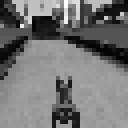

C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axis.py:1096: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


RuntimeError: libpng signaled error

<Figure size 0x2880 with 1 Axes>

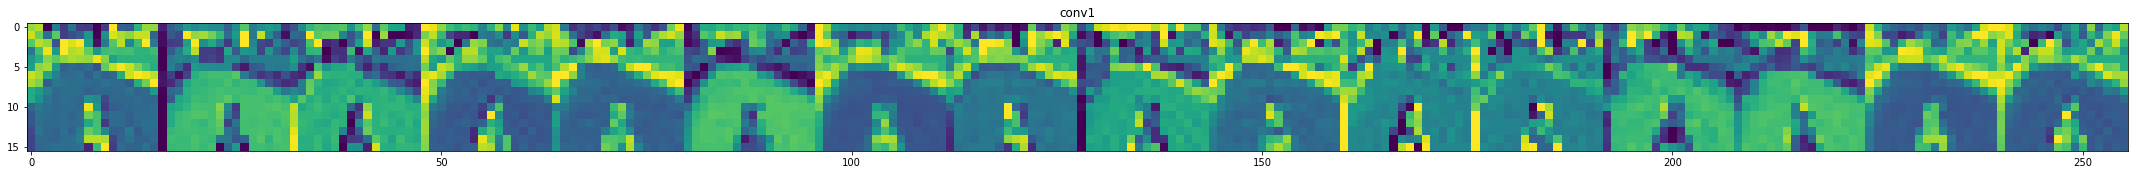

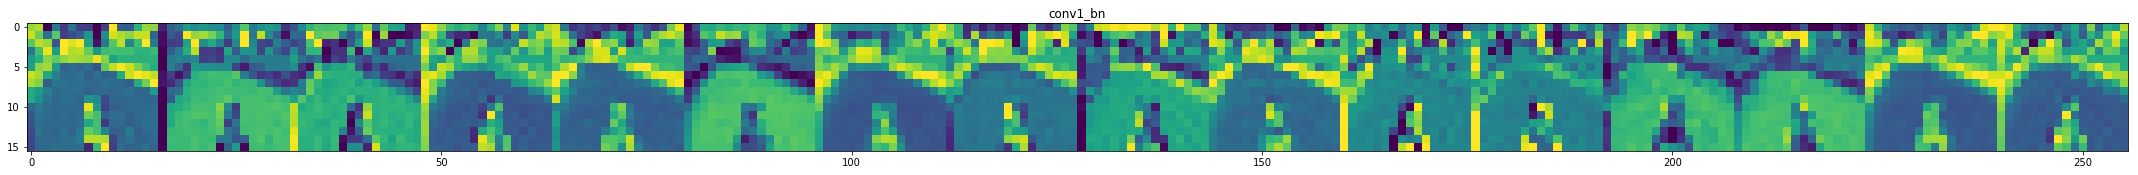

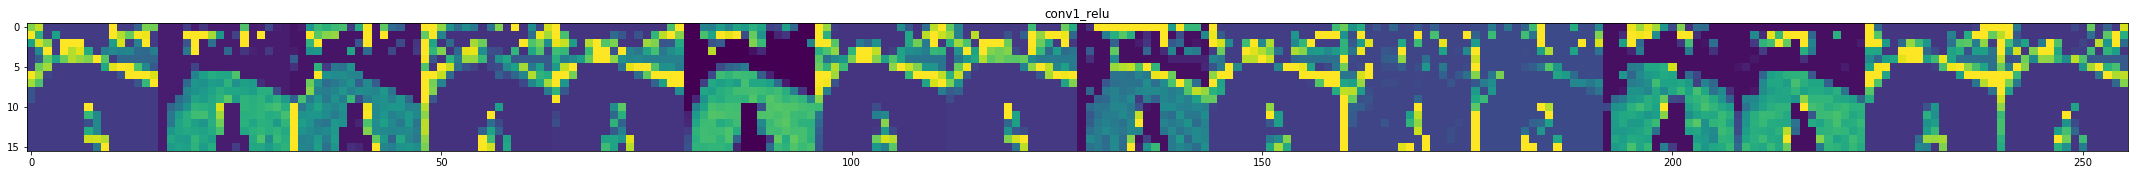

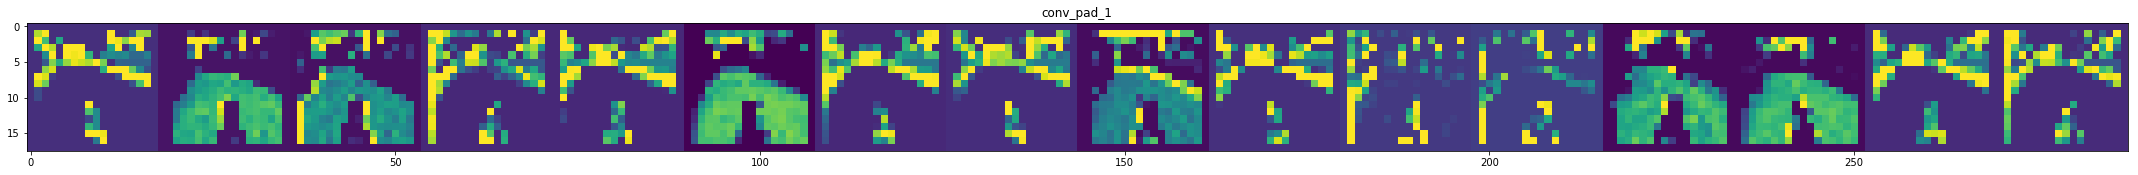

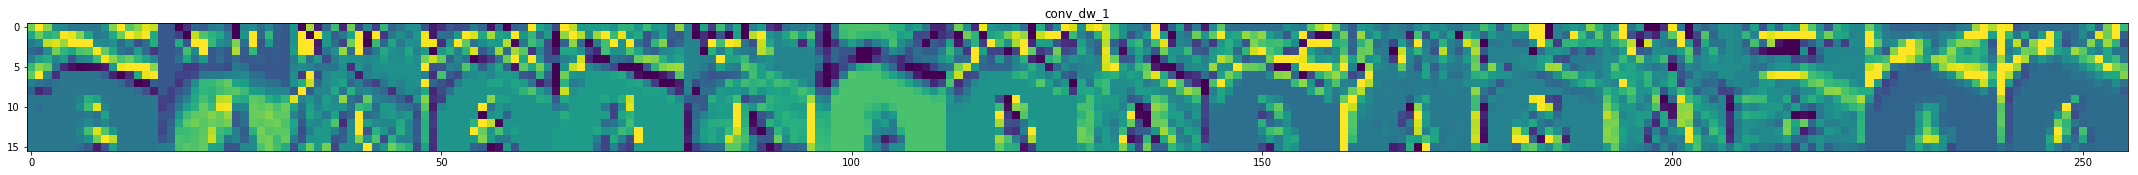

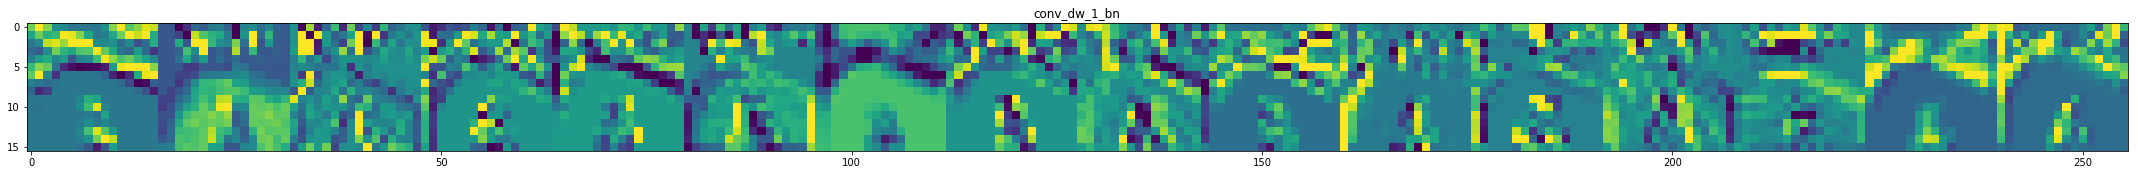

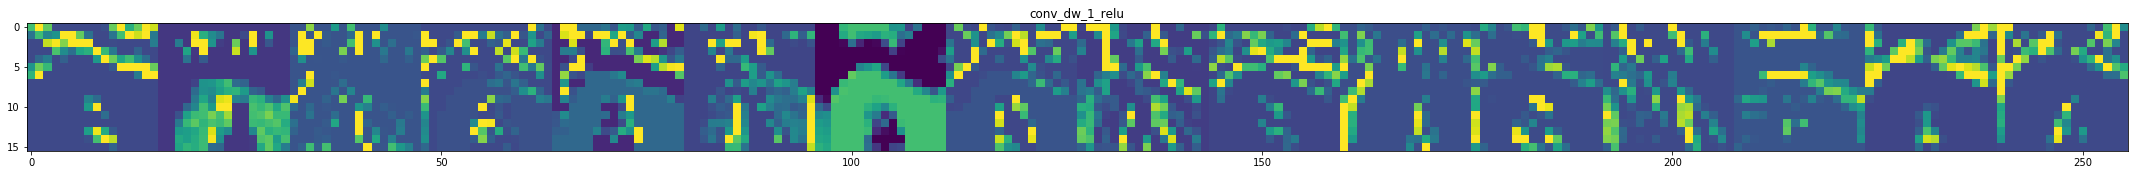

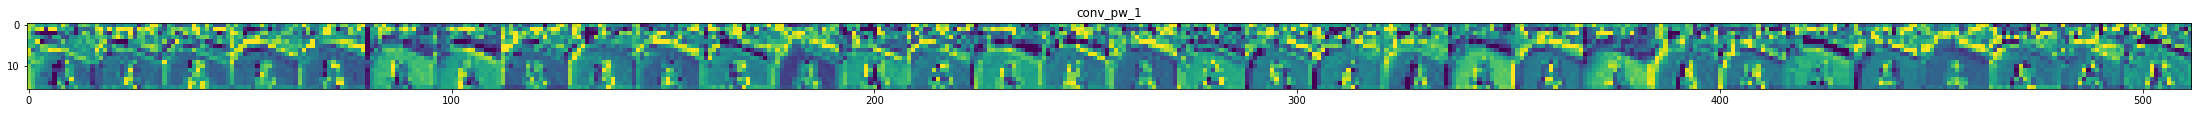

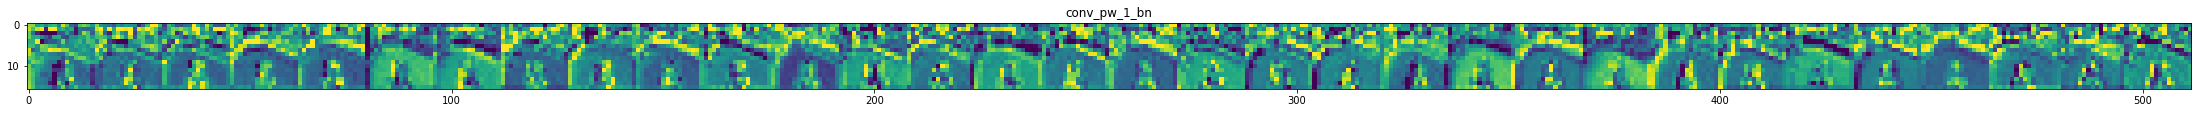

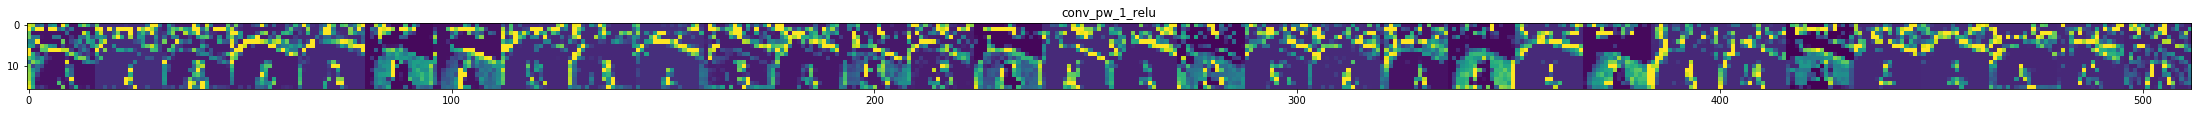

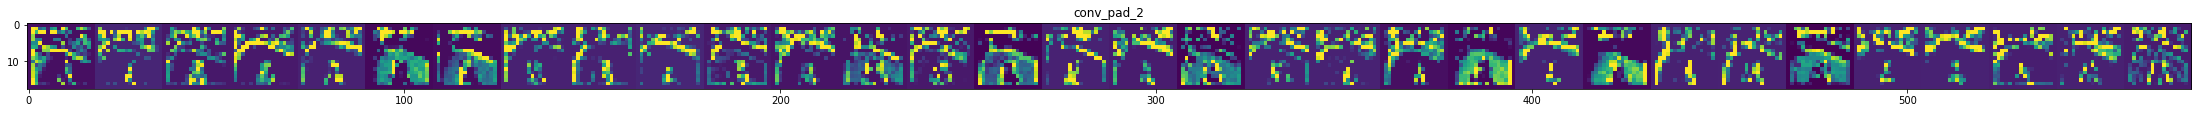

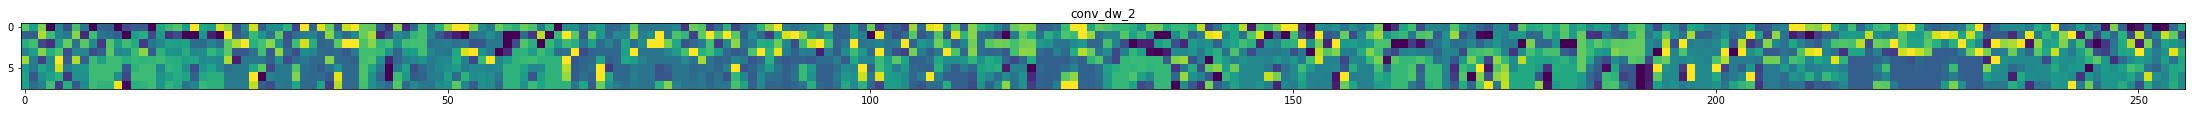

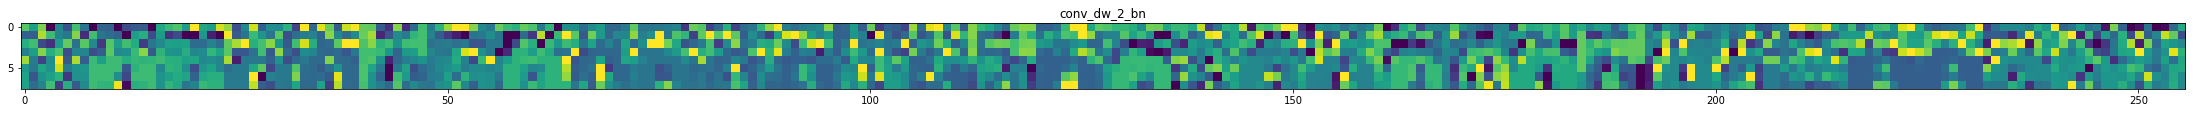

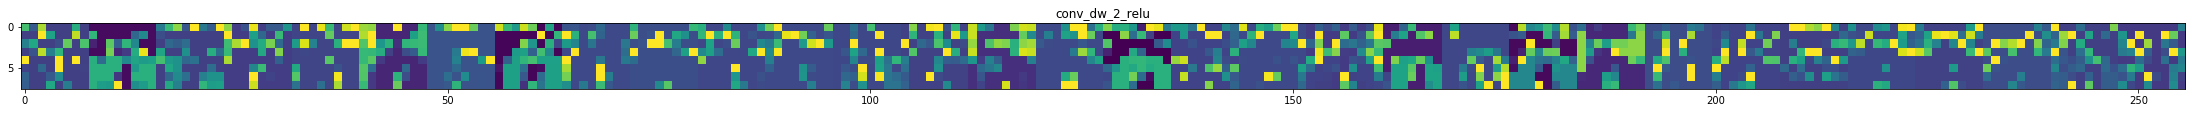

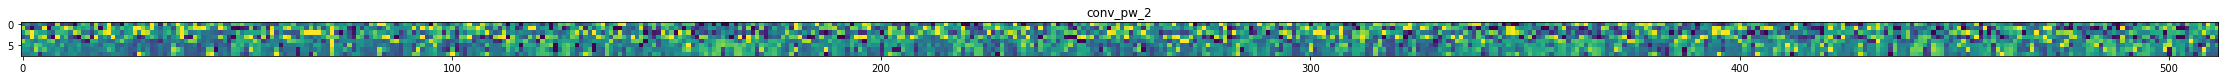

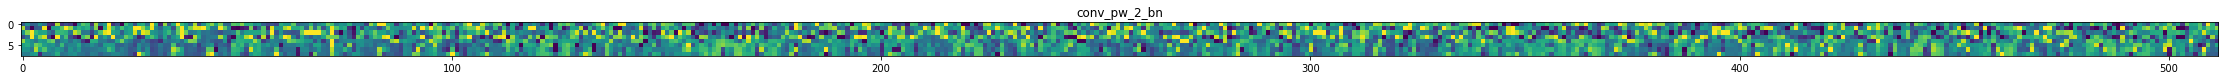

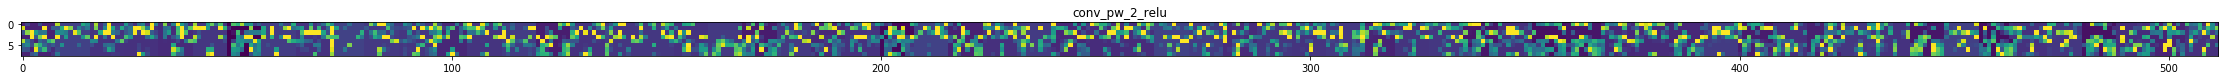

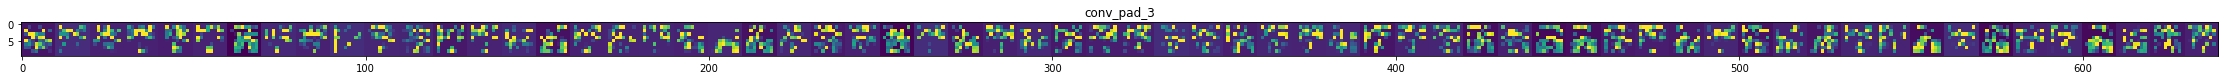

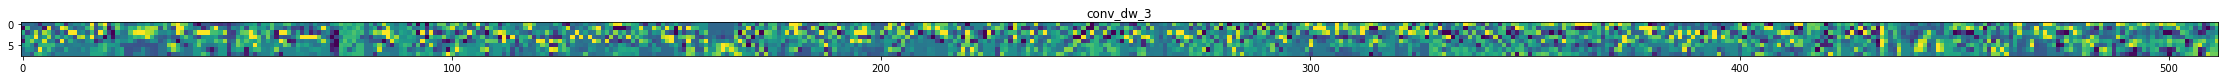

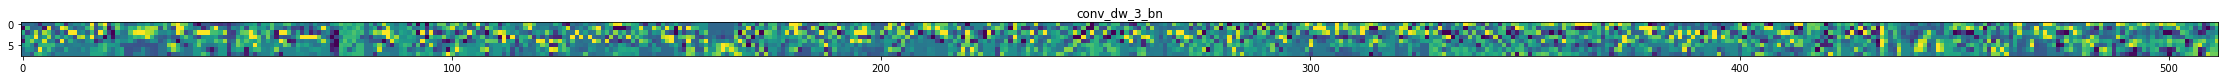

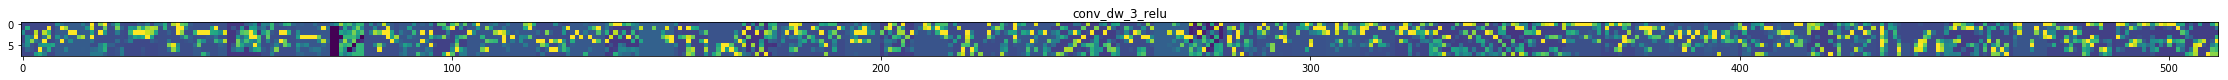

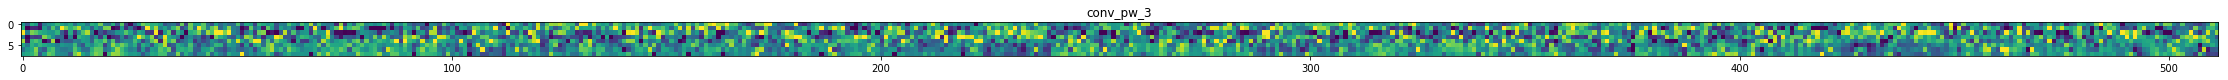

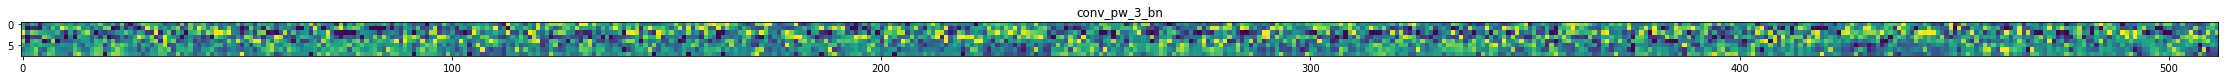

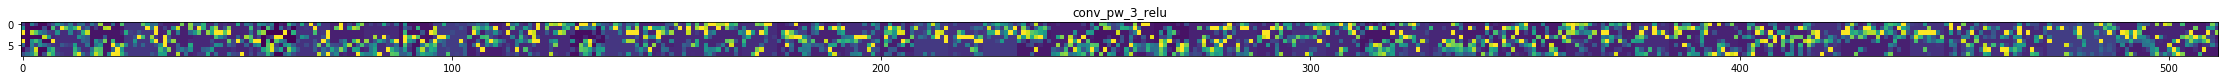

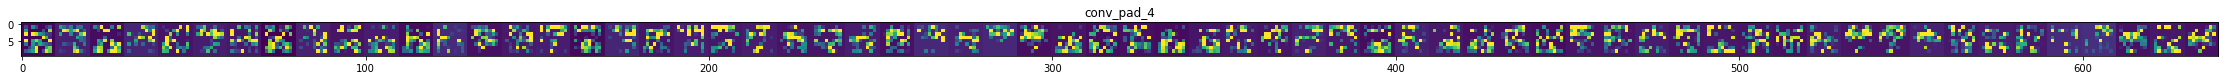

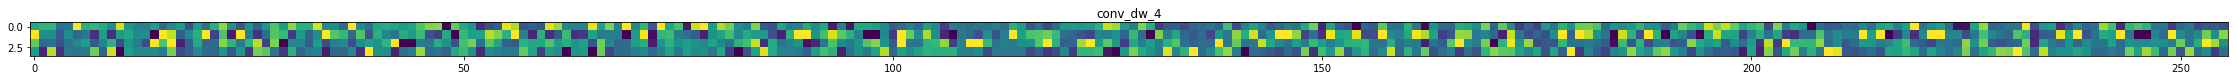

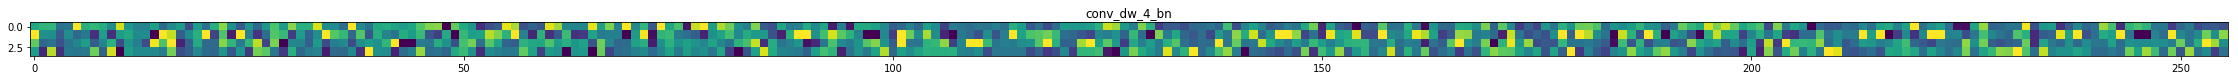

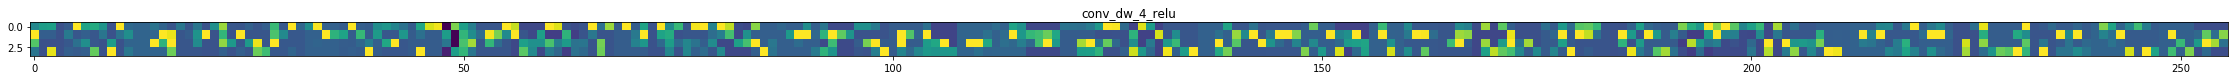

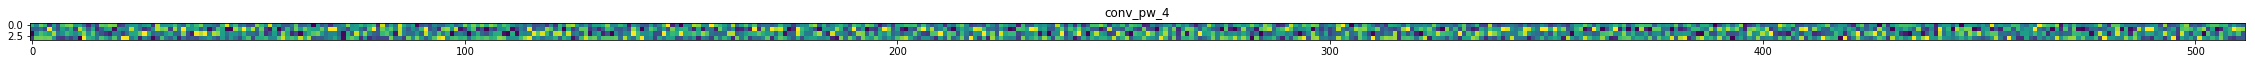

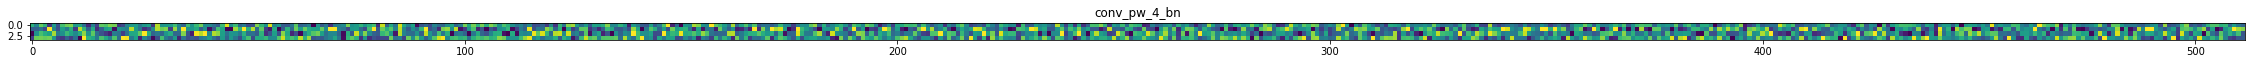

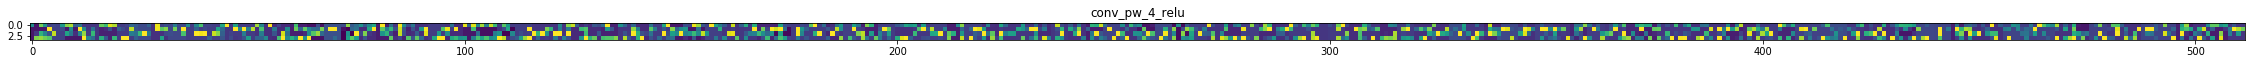

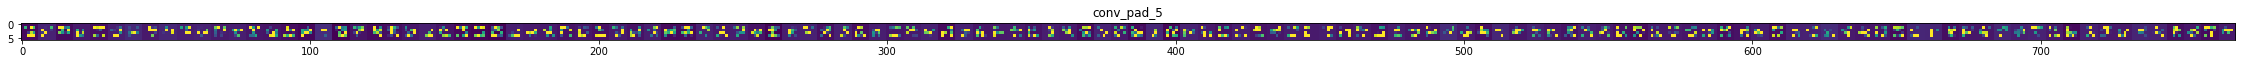

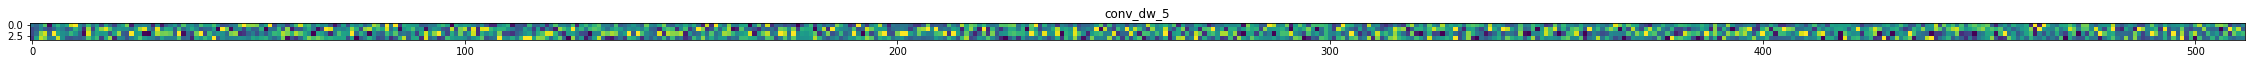

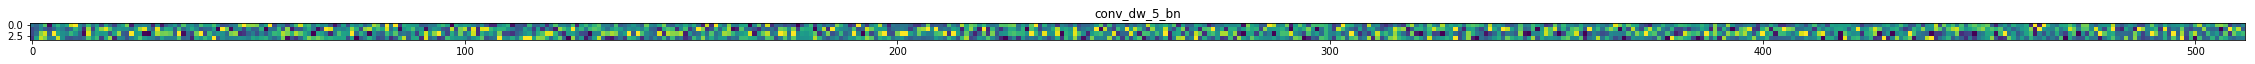

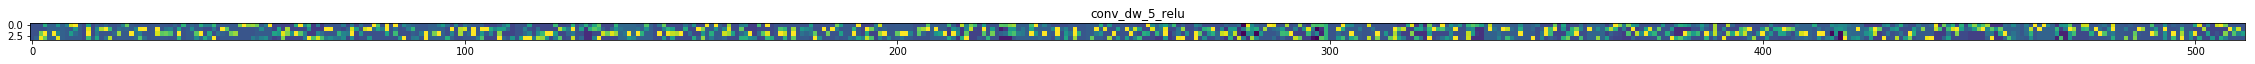

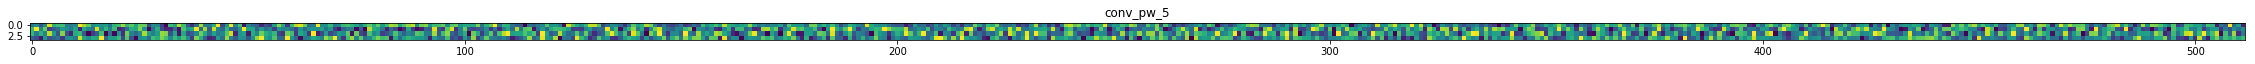

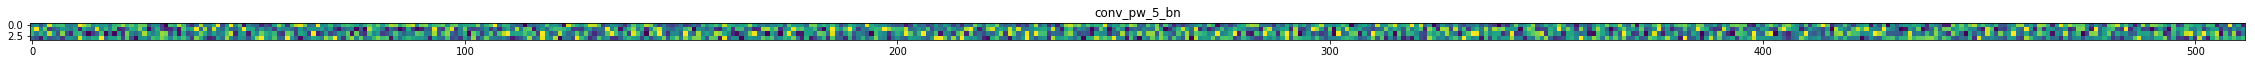

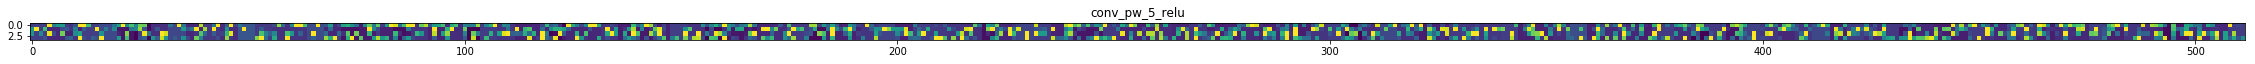

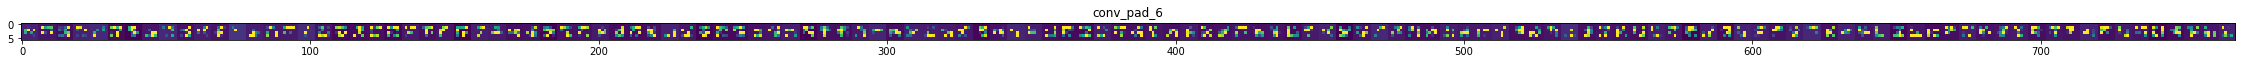

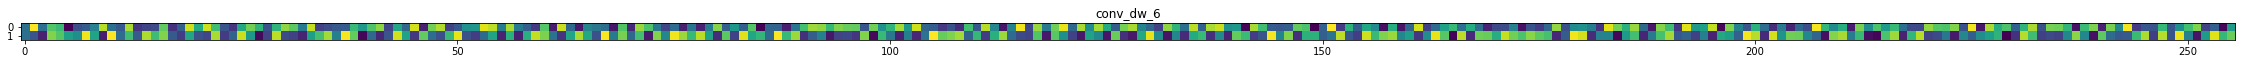

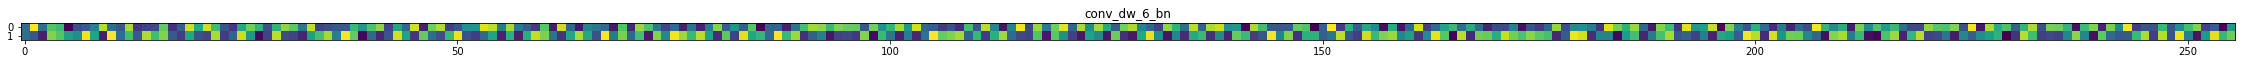

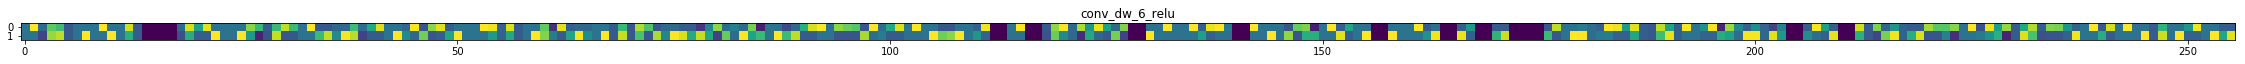

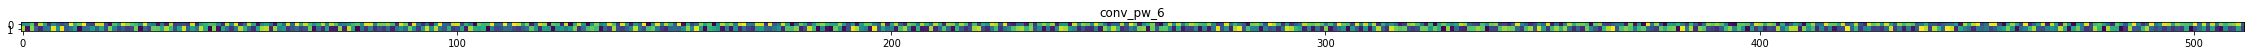

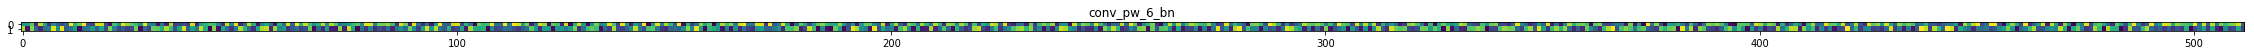

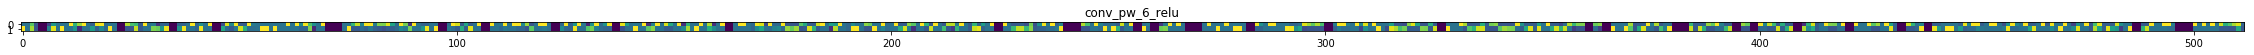

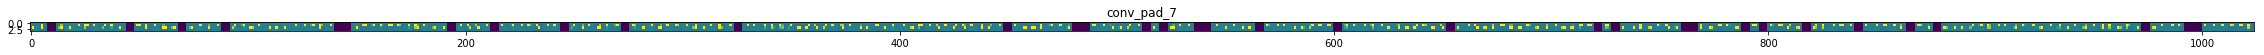

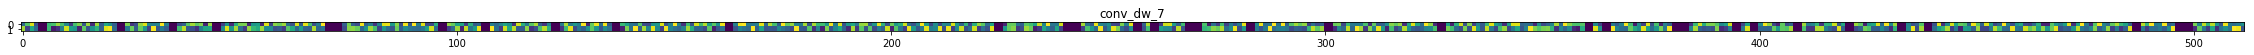

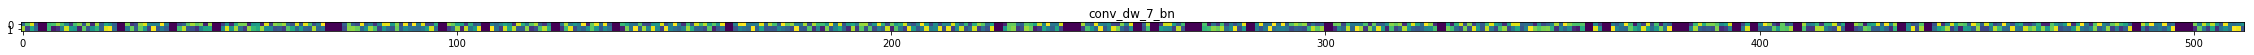

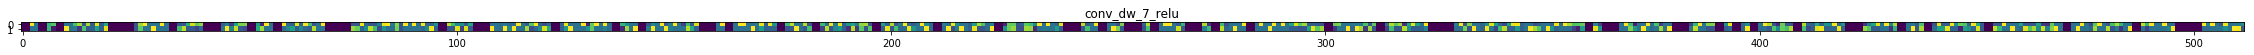

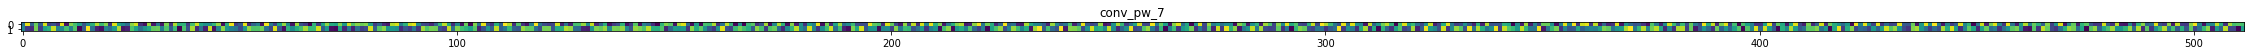

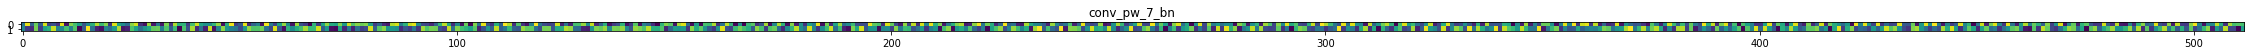

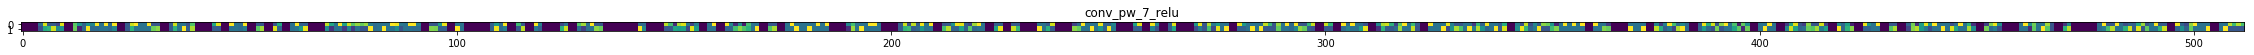

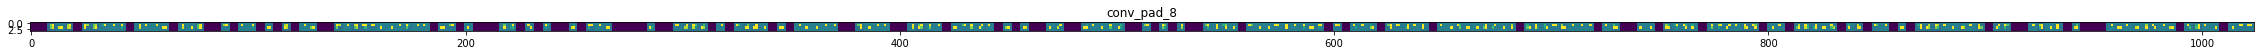

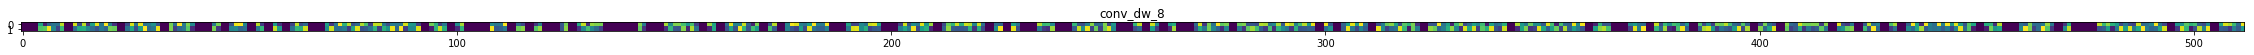

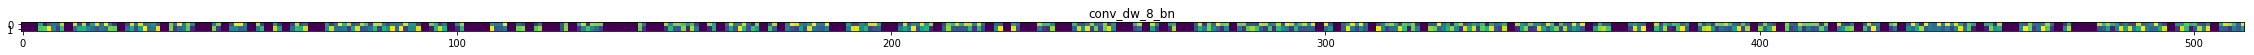

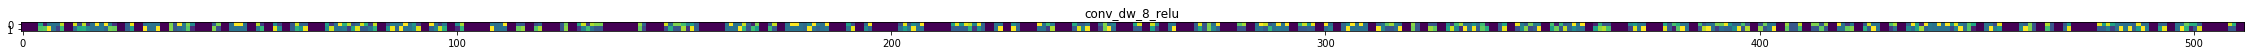

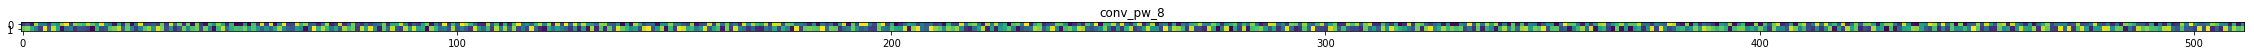

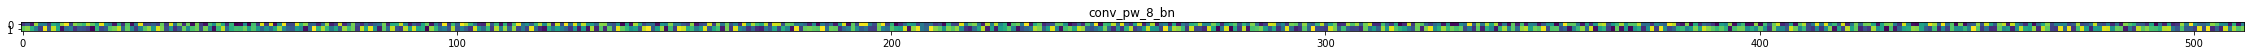

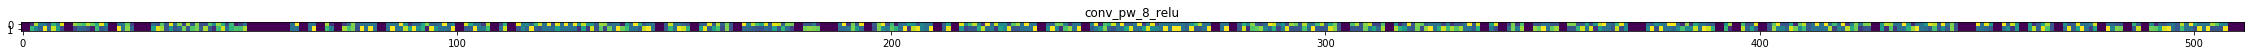

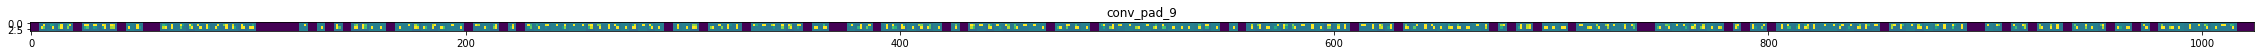

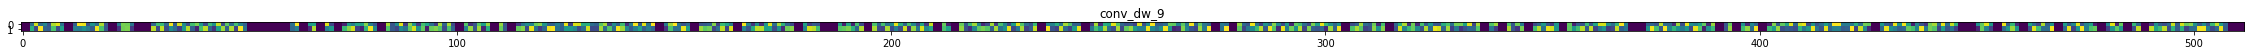

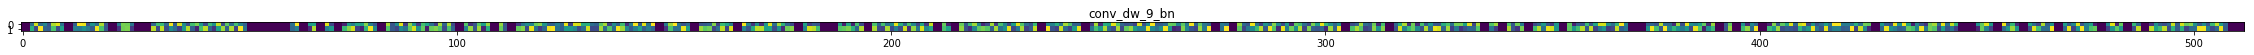

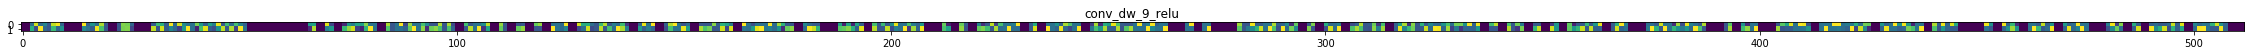

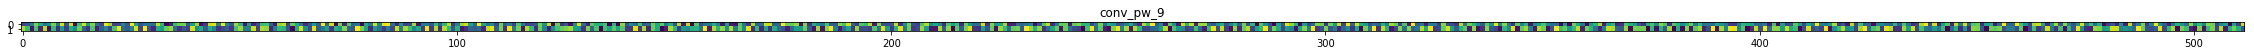

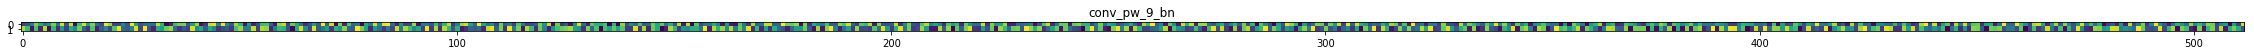

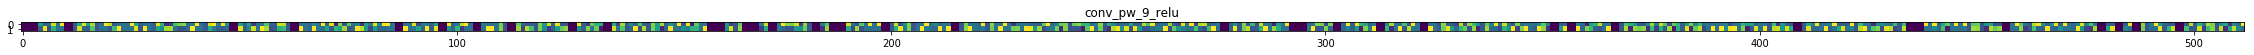

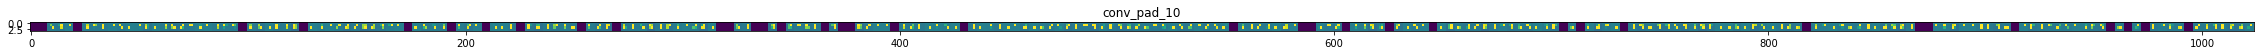

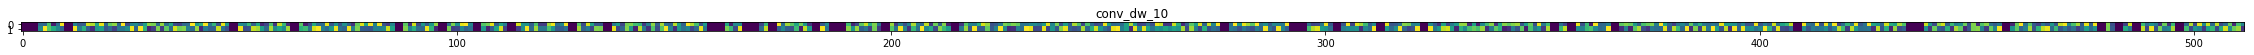

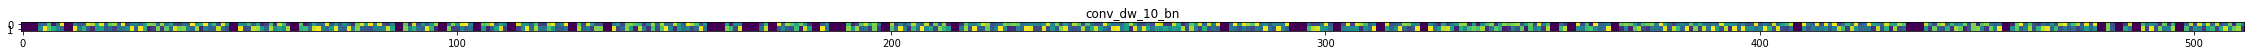

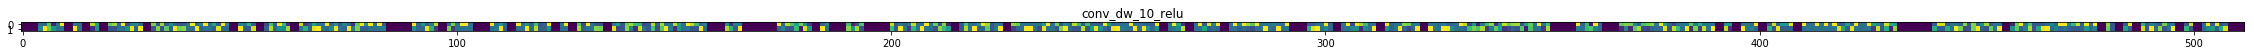

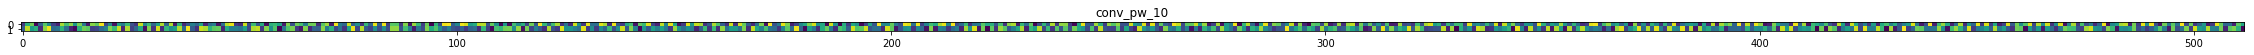

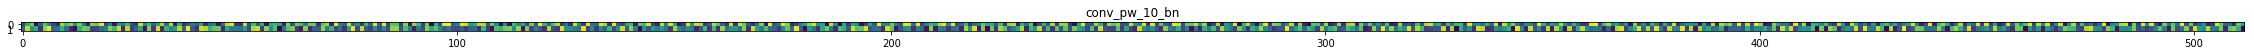

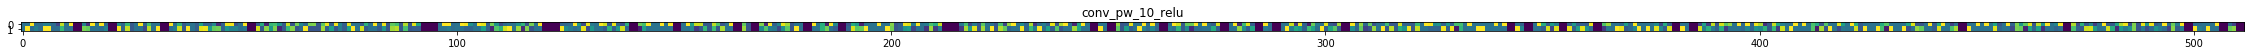

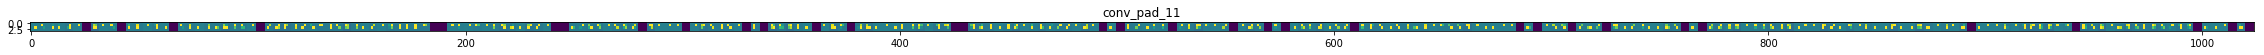

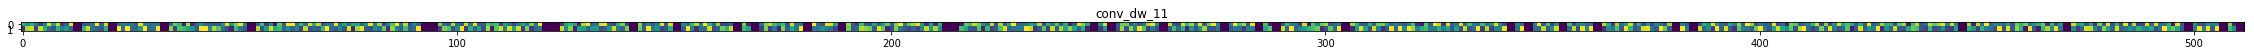

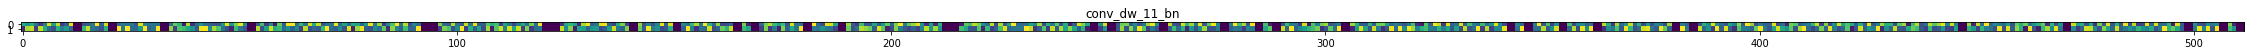

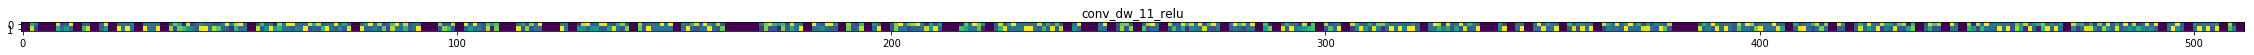

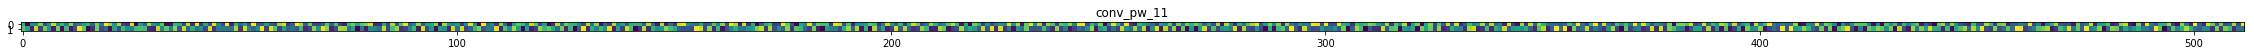

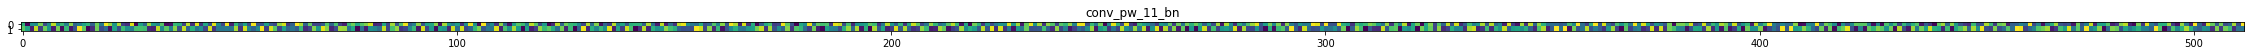

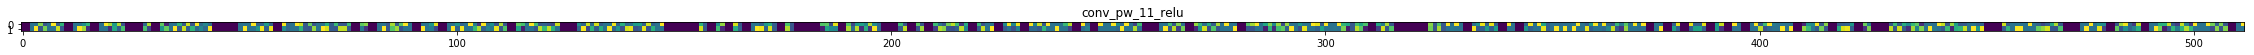

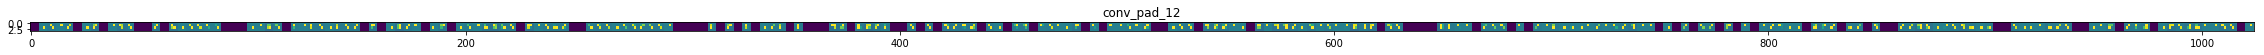

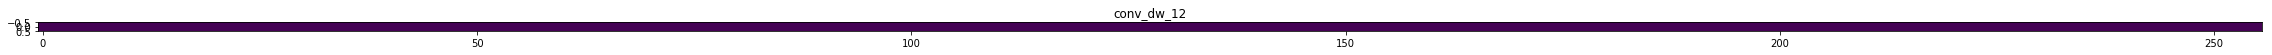

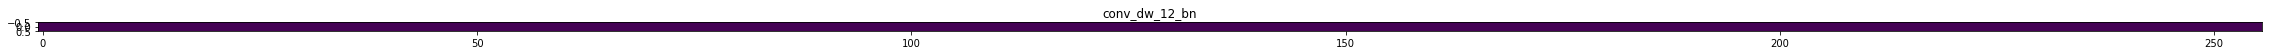

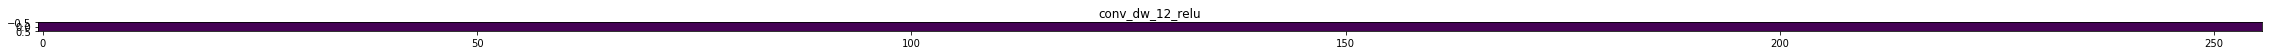

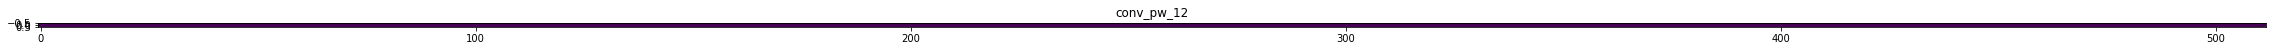

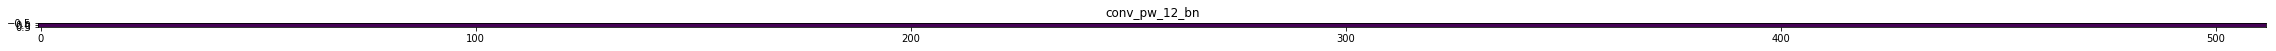

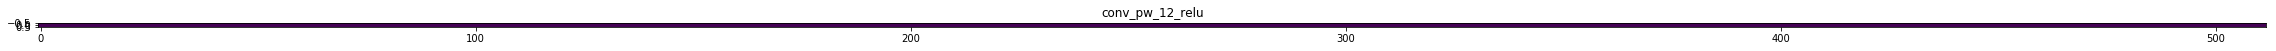

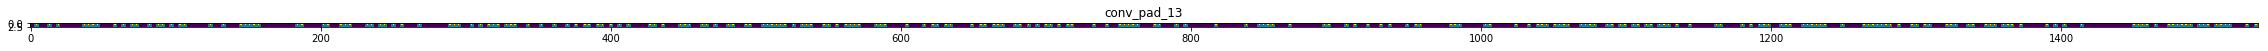

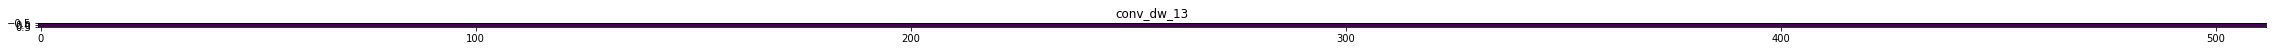

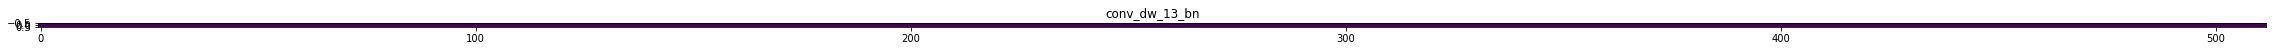

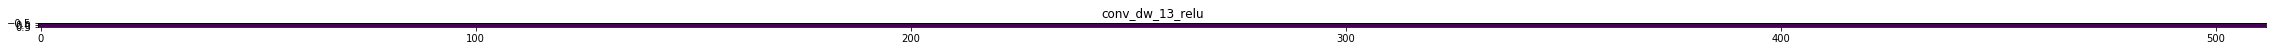

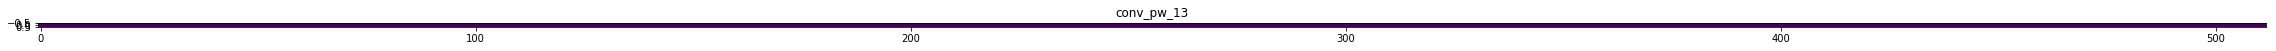

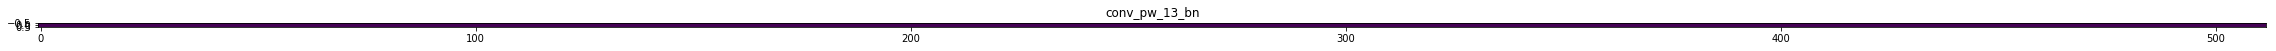

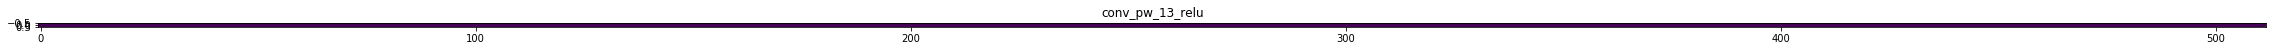

In [11]:
import numpy as np
import random
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt


# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(model.layers[0].input, successive_outputs)


img_path = random.choice(list((validation_dir / Path("AW")).iterdir()))
img = Image.open(img_path)
# img

x = np.array(img)
x = x.reshape((1,) + x.shape + (1,))
x = x / 255
# print(train_generator.class_indices)
print({index_class_dict[ind]: "{:3.1f}".format(pred) for ind, pred in enumerate(model.predict(x)[0])})

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names[1:], successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1] // 2  # number of features in feature map
        # The feature map has shape (1, height, width, n_features)
        height = feature_map.shape[1]
        width = feature_map.shape[2]
        # We will tile our images in this matrix
        display_grid = np.zeros((height, width * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * width: (i + 1) * width] = x
        # Display the grid
        scale = 40 / (n_features+1)
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        # plt.savefig("vis_{}.png".format(layer_name))
img.resize((128, 128))

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 160),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical"
)

Found 2341 images belonging to 9 classes.


In [37]:
evals = model.evaluate_generator(test_generator)

In [39]:
evals

[2.2181117311101137, 0.6851772770113743, 0.00854335753951303]

In [40]:
predictions = model.predict_generator(test_generator)

In [26]:
test_generator.class_indices

{'A': 0, 'AW': 1, 'D': 2, 'DW': 3, 'W': 4, 'no_key': 5}

In [41]:
x = []
y = []
k = 0
for e in test_generator:
    x.append(e[0])
    y.append(e[1])
    if k > 100:
        break
    k += 1
from itertools import chain

x = list(chain.from_iterable(x))
y = list(chain.from_iterable(y))

In [42]:
import numpy as np
predictions = model.predict(np.array(x))

In [43]:
maxs = np.argmax(predictions, axis=1)

In [44]:
max_y = np.argmax(y, axis=1)

In [45]:
max_y[:211]

array([7, 7, 2, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 5, 2, 7, 7, 7, 2,
       2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 3, 7,
       5, 7, 5, 2, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 2, 7, 3, 7, 3, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7,
       7, 7, 7, 2, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 3,
       7, 5, 7, 7, 7, 7, 7, 8, 2, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       2, 7, 2, 2, 2, 7, 7, 2, 2, 2, 7, 7, 5, 2, 2, 7, 2, 7, 2, 7, 2, 7,
       7, 7, 2, 7, 7, 7, 2, 8, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 7, 7, 7, 7,
       7, 5, 7, 7, 3, 7, 7, 8, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 2, 8, 7, 7,
       7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7], dtype=int64)

In [46]:
misclassified = []
for k in range(len(y)):
    if max_y[k] != maxs[k]:
        misclassified.append(k)

In [47]:
len(misclassified)

636

In [48]:
from PIL import Image
from random import choice

In [49]:
key_dict = {j: i for i, j in test_generator.class_indices.items()}

In [57]:
nr = choice(misclassified)
img = Image.fromarray((x[nr].reshape((x[nr].shape[0], x[nr].shape[1]))*255).astype("int8"), mode="L")
print("actual:", key_dict[max_y[nr]])
print("predicted:", key_dict[maxs[nr]], "with score = ", predictions[nr][maxs[nr]])
print("predicted score of actual:", predictions[nr][max_y[nr]])
img.show()

actual: W
predicted: D with score =  0.71044207
predicted score of actual: 0.28603935


Test image generator

In [1]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    fill_mode='nearest',
    channel_shift_range=2,
    rotation_range=2,
    shear_range=2,
    width_shift_range=2,
    height_shift_range=2
)

C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


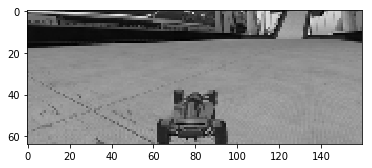

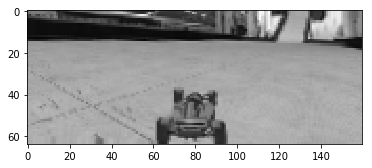

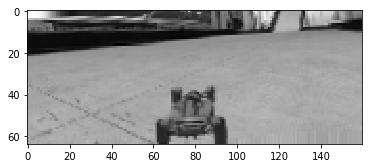

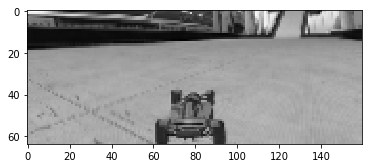

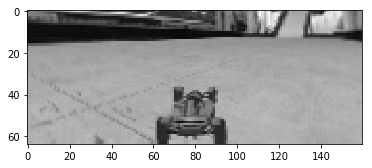

In [4]:
%matplotlib inline
# %matplotlib auto 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = r"E:\Trackmania Data\training_val_data\training_data\DW\ 1114.png"
img = load_img(img_path).convert("L").resize((160, 64))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
plt.figure(0)
imgplot = plt.imshow(img)
i = 1
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break